In [9]:
import numpy as np
import pandas as pd
from bisect import bisect

from numba import njit, prange
from matplotlib import pyplot as plt

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
dir_path = 'waypoints.csv'
df = pd.read_csv(dir_path)
x = df['X-axis'].values.tolist()
y = df['Y-axis'].values.tolist()

In [25]:
class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = len(x)
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.a[i] + self.b[i]*delta_x + self.c[i]*delta_x*delta_x + self.d[i]*delta_x*delta_x*delta_x

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*delta_x + 3.0*self.d[i]*delta_x*delta_x

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * delta_x

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        delta_x = np.ediff1d(x)
        deltay = np.ediff1d(y)
        self.ds = np.hypot(delta_x, deltay)

        return np.concatenate((np.zeros(1), np.cumsum(self.ds)))

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx*dx + dy*dy)**1.5)

        return k

def generate_cubic_path(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

%lprun -f generate_cubic_path generate_cubic_path(x, y)

NameError: name 'vectorize' is not defined

In [17]:
def generate_cubic_path_numba(x, y, ds=0.05):

    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    s = calculate_s(x, y)
    x_coeffs = calculate_coefficients(s, x)
    return x_coeffs
    y_coeffs = calculate_coefficients(s, y)
    s_range = np.arange(0, s[-1], ds)
    x, y = calculate_position(s_range)

@njit(parallel=True)
def calculate_coefficients(s, x):
    
    h = np.ediff1d(s)
    a = x
    size = len(s)

    A = np.zeros((size, size))
    A[0, 0] = 1.0

    for i in range(size - 1):
        if i == size - 2:
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

    B = np.zeros(size)

    for i in prange(size - 2):
        B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / h[i + 1] - 3.0 * (a[i + 1] - a[i]) / h[i]

@njit
def calculate_s(x, y):

    dx = np.ediff1d(x)
    dy = np.ediff1d(y)
    ds = np.hypot(dx, dy)

    return np.concatenate((np.zeros(1), np.cumsum(ds)))

@njit
def calculate_position():
    pass
    
    return x, y

%lprun -f generate_cubic_path_numba print(generate_cubic_path_numba(x, y))

None


Timer unit: 1e-06 s

Total time: 1.58593 s
File: <ipython-input-17-1b98088b97c9>
Function: generate_cubic_path_numba at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def generate_cubic_path_numba(x, y, ds=0.05):
     2                                           
     3         1         10.0     10.0      0.0      x = np.array(x, dtype=np.float64)
     4         1          2.0      2.0      0.0      y = np.array(y, dtype=np.float64)
     5         1     387577.0 387577.0     24.4      s = calculate_s(x, y)
     6         1    1198345.0 1198345.0     75.6      x_coeffs = calculate_coefficients(s, x)
     7         1          1.0      1.0      0.0      return x_coeffs
     8                                               y_coeffs = calculate_coefficients(s, y)
     9                                               s_range = np.arange(0, s[-1], ds)
    10                                               x, y = calculate_po

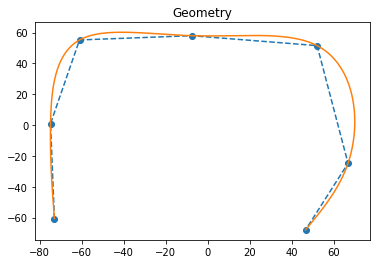

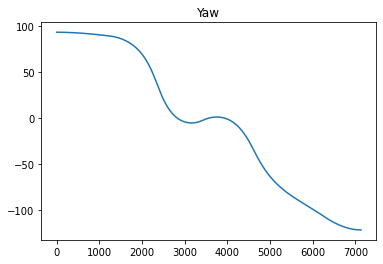

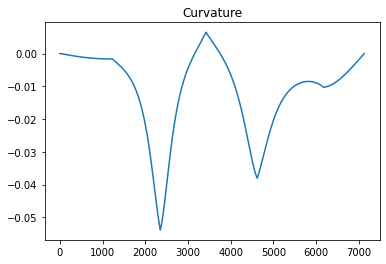

In [7]:
%matplotlib inline

px, py, pyaw, pk = generate_cubic_path(x, y)

plt.figure(1)
plt.title("Geometry")
plt.plot(x, y, '--o')
plt.plot(px, py)

plt.figure(2)
plt.title("Yaw")
plt.plot(np.rad2deg(pyaw))

plt.figure(3)
plt.title("Curvature")
plt.plot(pk)

plt.show()